In [22]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model


In [23]:
data=pd.read_csv('july-dataset4.csv')
humidity = data['Humidity']
Epoch_Time = data['Epoch_Time']
Cloud_Cover = data['Cloud_Cover']
Dew_Point = data['Dew_Point']
Humidity = data['Humidity']
Pressure = data['Pressure']
Temperature = data['Temperature']
Wind_Speed = data['Wind_Speed']
Visibility = data['Visibility']
Hour_map = data['Hour_map']

In [20]:
Hour_map

0       0.0000
1       0.0035
2       0.0069
3       0.0104
4       0.0139
5       0.0174
6       0.0208
7       0.0243
8       0.0278
9       0.0313
10      0.0347
11      0.0382
12      0.0417
13      0.0451
14      0.0486
15      0.0521
16      0.0556
17      0.0590
18      0.0625
19      0.0660
20      0.0694
21      0.0729
22      0.0764
23      0.0799
24      0.0833
25      0.0868
26      0.0903
27      0.0938
28      0.0972
29      0.1007
         ...  
8898    0.9097
8899    0.9132
8900    0.9167
8901    0.9201
8902    0.9236
8903    0.9271
8904    0.9306
8905    0.9340
8906    0.9375
8907    0.9410
8908    0.9444
8909    0.9479
8910    0.9514
8911    0.9549
8912    0.9583
8913    0.9618
8914    0.9653
8915    0.9688
8916    0.9722
8917    0.9757
8918    0.9792
8919    0.9826
8920    0.9861
8921    0.9896
8922    0.9931
8923    0.9965
8924    0.9999
8925    0.9999
8926    0.9999
8927    0.9999
Name: Hour_map, Length: 8928, dtype: float64

In [24]:
def spliting_data(df, training_percent = 0.7, validation_percent = 0.15, testing_percent = 0.15, seed = None):
    np.random.seed(seed)
    total_size = training_percent + validation_percent + testing_percent
    if total_size != 1:
        raise ValueError('total size must be 1 not {}'.format(total_size))
    training_end = int(training_percent * len(df))
    validate_end = int(validation_percent * len(df)) + training_end
    perm = np.random.permutation(df.index) # randomize indexs
    training = perm[:training_end]
    validate = perm[training_end:validate_end]
    testing = perm[validate_end:]
    return training, validate, testing
def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)

def z_score(col, stats):
    m, M, mu, s = stats
    df2 = pd.DataFrame()
    for c in col.columns:
        df2[c] = (col[c]-mu[c])/s[c]
    return df2
def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.5))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='rmsprop',
        metrics=[metrics.mae])
    return(t_model)

In [25]:
training,validate,testing = spliting_data(data)
df = pd.DataFrame(data, columns=[
        'Cloud_Cover',
        'Hour_map',
        'Power_Output'])
label_col = 'Power_Output'
y_train = df.loc[training, [label_col]]
x_train = df.loc[training, :].drop(label_col, axis=1)
y_valid = df.loc[validate, [label_col]]
x_valid = df.loc[validate, :].drop(label_col, axis=1)

print('Size of training set: ', len(x_train))
print('Size of validation set: ', len(x_valid))
print('Size of test set: ', len(testing), '(not converted)')
stats = norm_stats(x_train, x_valid)
arr_x_train = np.array(z_score(x_train, stats))
arr_y_train = np.array(y_train)
arr_x_valid = np.array(z_score(x_valid, stats))
arr_y_valid = np.array(y_valid)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])

Size of training set:  6249
Size of validation set:  1339
Size of test set:  1340 (not converted)
Training shape: (6249, 2)
Training samples:  6249
Validation samples:  1339


In [26]:
model = basic_model_3(arr_x_train.shape[1], arr_y_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 80)                240       
_________________________________________________________________
dropout_5 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               9720      
_________________________________________________________________
dropout_6 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                2420      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                210       
__________

In [27]:
epochs = 100
batch_size = 2

print('Epochs: ', epochs)
print('Batch size: ', batch_size)
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]
history = model.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=2, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

Epochs:  100
Batch size:  2
Train on 6249 samples, validate on 1339 samples
Epoch 1/100
 - 4s - loss: 220644954.4825 - mean_absolute_error: 12040.8216 - val_loss: 198841803.1017 - val_mean_absolute_error: 12348.7578
Epoch 2/100
 - 4s - loss: 184987167.1029 - mean_absolute_error: 11723.3957 - val_loss: 160702682.5063 - val_mean_absolute_error: 11076.4435
Epoch 3/100
 - 4s - loss: 122884940.2945 - mean_absolute_error: 9138.7948 - val_loss: 52621205.2314 - val_mean_absolute_error: 5808.0376
Epoch 4/100
 - 4s - loss: 75931046.3494 - mean_absolute_error: 6259.4879 - val_loss: 34364744.2187 - val_mean_absolute_error: 4187.3197
Epoch 5/100
 - 4s - loss: 66219279.9765 - mean_absolute_error: 5570.2523 - val_loss: 28380215.5069 - val_mean_absolute_error: 3426.9896
Epoch 6/100
 - 4s - loss: 57704815.6387 - mean_absolute_error: 5052.8640 - val_loss: 26285642.6408 - val_mean_absolute_error: 3222.5733
Epoch 7/100
 - 4s - loss: 53347590.1346 - mean_absolute_error: 4805.7889 - val_loss: 28531745.0668 

Epoch 61/100
 - 4s - loss: 27643475.8303 - mean_absolute_error: 2949.4177 - val_loss: 33864400.3908 - val_mean_absolute_error: 3713.7457
Epoch 62/100
 - 4s - loss: 26714869.1823 - mean_absolute_error: 2891.1251 - val_loss: 34337673.1895 - val_mean_absolute_error: 3741.7341
Epoch 63/100
 - 4s - loss: 27149855.8135 - mean_absolute_error: 2917.2838 - val_loss: 22349928.4166 - val_mean_absolute_error: 2721.8595
Epoch 64/100
 - 4s - loss: 27200507.0564 - mean_absolute_error: 2900.5055 - val_loss: 24640485.5675 - val_mean_absolute_error: 2989.3642
Epoch 65/100
 - 4s - loss: 28219984.2118 - mean_absolute_error: 3004.3801 - val_loss: 24529571.4345 - val_mean_absolute_error: 2963.2816
Epoch 66/100
 - 4s - loss: 27373337.1953 - mean_absolute_error: 2938.7382 - val_loss: 32906615.2233 - val_mean_absolute_error: 3697.3989
Epoch 67/100
 - 4s - loss: 27973762.8220 - mean_absolute_error: 2943.7230 - val_loss: 27146103.9713 - val_mean_absolute_error: 3241.9717
Epoch 68/100
 - 4s - loss: 27510475.0142 

In [28]:
plot_hist(history.history, xsize=8, ysize=12)

NameError: name 'plot_hist' is not defined

In [14]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=2)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=2)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  2243.6351 , Train Loss:  18329643.2357
Val MAE:  2147.4012 , Val Loss:  16000532.3495


In [15]:
y=model.predict_on_batch()

ValueError: Error when checking : expected dense_1_input to have shape (None, 2) but got array with shape (1340, 1)

In [39]:
dataForTest1 = np.array([1530400800,0.35,48.85,0.65,1009.48,60.51,0.00,6.22,0.1]) 

In [35]:
data2 = pd.read_csv('july-dataset4.csv')
data2 = data2.drop('Power_Output',1)
data2 = data2.drop('Epoch_Time',1)
data2 = data2.drop('Dew_Point',1)
data2 = data2.drop('Pressure',1)
data2 = data2.drop('Wind_Speed',1)
data2 = data2.drop('Visibility',1)
data2 = data2.drop('Humidity',1)
data2 = data2.drop('Temperature',1)

In [36]:
data2 = data2.values
predicted = model.predict(data2)

In [37]:
data3 = pd.read_csv('july-dataset4.csv')
real = data3['Power_Output']
cloud = data3['Cloud_Cover']

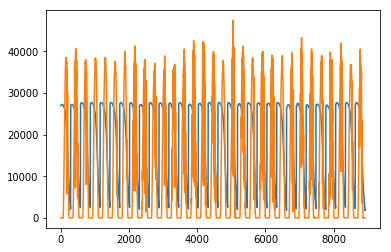

In [42]:
plt.plot(predicted)
plt.plot(real)
plt.show()

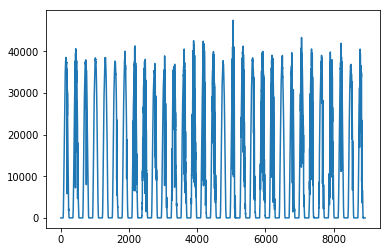

In [39]:

plt.show()

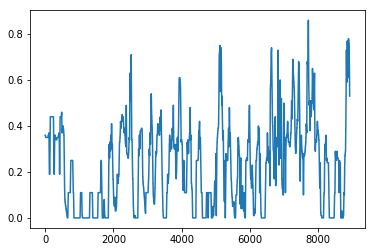

In [40]:
plt.plot(cloud)
plt.show()

In [41]:
predicted.to_csv('predicted_neural_net.csv',index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'